# Virtual Event Assistant with Message Summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

This chatbot serves as a **virtual event assistant** that:
- Maintains conversation flow while summarizing older interactions
- Retains only the **last two messages** after summarization to reduce LLM token usage
- Uses Mistral AI for efficient conversation management
- Supports long-running conversations through LangGraph persistence

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a virtual event assistant chatbot with memory, supporting long-running conversations without incurring high token cost / latency.


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_mistralai



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing) to track conversation threads and confirm persistence works.


In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "virtual-event-assistant"


In [4]:
from langchain_mistralai import ChatMistralAI
model = ChatMistralAI(model="mistral-large-latest", temperature=0)


We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).


In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str


We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

This node acts as the core of our virtual event assistant, providing context-aware responses.


In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    
    summary = state.get("summary", "")

    if summary:
        
        system_message = f"You are a helpful virtual event assistant. Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = [SystemMessage(content="You are a helpful virtual event assistant. Help users with event information, schedules, and attendee queries.")] + state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}


We'll define a node to produce a summary.

**Key Tweak**: After summarization, only the **last two messages are retained** to reduce LLM token usage while maintaining conversation flow.


In [ ]:
def summarize_conversation(state: State):
    
    summary = state.get("summary", "")

    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


We'll add a conditional edge to determine whether to produce a summary based on the conversation length.


In [ ]:
from langgraph.graph import END
from typing_extensions import Literal

def should_continue(state: State) -> Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END


## Adding Memory for Virtual Event Assistant

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

We'll use `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!


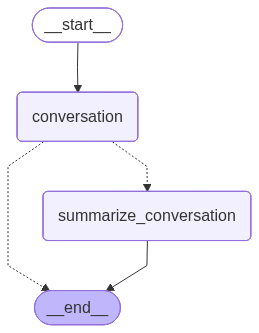

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


## Threads - Tracking Conversations in LangSmith

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID. **Track this thread in LangSmith to confirm persistence works!**


In [ ]:
config = {"configurable": {"thread_id": "event-assistant-1"}}

input_message = HumanMessage(content="Hi! I'm here for the tech conference. Can you help me?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What sessions are available today?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I'm interested in AI and machine learning topics")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()


================================== Ai Message ==================================

Hello! Welcome to the tech conference—I’d be happy to help. Here’s how I can assist you:

### **Quick Links:**
1. **Event Schedule** – Need the agenda, keynote times, or session details?
2. **Speaker Info** – Looking for bios, talk abstracts, or Q&A sessions?
3. **Venue & Logistics** – Directions, Wi-Fi, food, or accessibility info?
4. **Networking** – Attendee list, social events, or how to connect with others?
5. **Tech Support** – Issues with the event app, live stream, or virtual platform?
6. **FAQs** – Badge pickup, dress code, recording policies, etc.?

**What do you need help with first?**
*(Example: "When is the AI keynote?" or "Where’s the lunch area?")*
================================== Ai Message ==================================

Here’s today’s **session lineup** at the tech conference, organized by time and track. All times are in the event’s local time zone (**check your badge/app for conf

Now, we don't yet have a summary of the state because we still have <= 6 messages.

This was set in `should_continue`. 
